In [1]:
import pandas as pd
import sqlite3 as sq
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings, re
import nltk
from IPython.display import Image
import datetime
from collections import Counter
warnings.filterwarnings('ignore')
%matplotlib inline
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 1000)
from sklearn.decomposition import NMF
from scipy import stats
from sklearn.metrics import explained_variance_score
from pylab import rcParams
from collections import Counter
import scipy as sp
from scipy.spatial import distance
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import networkx as nx
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import networkx as nx
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import StandardScaler

### 1. Load the dataset containing person IDs of the studied pairs

In [2]:
pairs = pd.read_pickle('new_pairs_all_rests')

df_pairs_frequencies = pd.DataFrame(pd.Series(pairs.index).apply(lambda x: x.split(' ')))
df_pairs_frequencies['frequency'] = pairs.values

cohort = df_pairs_frequencies.loc[(df_pairs_frequencies['frequency']>= 10)].copy() 

cohort.columns = ['pair','frequency']

tmp = cohort['frequency'].values

Ns = []
for i in tmp:
    Ns.extend([i, i])

### 2. Load the derived dataframe with persons' pre-processed features

In [3]:
df_participants = pd.read_pickle("df_focal_persons.pkl")
df_participants['N'] = Ns

### 3. Keep only persons with a single partner

In [4]:
df_participants_single = df_participants.groupby("ID").filter(lambda x: len(x) == 1)

In [5]:
len(df_participants)

42720

In [6]:
len(df_participants_single)

5039

### 4. Do the matching

### a) first pass: generate potential persons for fitting propensity scores. Here we check the range of malanhobis distance which is important for normalization

In [7]:
VI = np.linalg.inv(pd.DataFrame(np.array([df_participants_single["meals_percentage"].apply(np.nanmean).values,
df_participants_single["lunchtime_percentage"].apply(np.nanmean).values,
df_participants_single["transactions_per_month"].apply(np.nanmean).values]).T).cov())

In [8]:
#iterate through all who start with someone who has positive score.
#match with similar people, but start
#   -at the same time (in the same month)
#   -with someone with a negative score


count = 0

#check the range of malanhobis distance, this is needed to convert distance to similarity
malanhobis_dist = []

#extract features control and treated used to fit propensities

X_treated_high = []
X_treated_low = []

for i in range(len(df_participants_single)):

    count +=1
    if count % 500 == 0:
        print(str(count)+'/'+str(len(df_participants_single)))
    
    #isolate focals who start with a positive partner
    #find all possible matched focals who start with a negative partner
    if df_participants_single.iloc[i]["partner_score_pre_treatment"] >= 0.05 and df_participants_single.iloc[i]["N"]>=10:

        scores = df_participants_single.iloc[i]["monthly_scores"]

        start = int(df_participants_single.iloc[i]["start_treatment"])
        
        #6 months pre-treatment
        #6 months post-treatment
        avg_pre = np.nanmean(scores[start-5:start+1])
        avg_post = np.nanmean(scores[start+1:start+7])

        months_pre = np.array(range(len(scores)))[start-5:start+1]
        months_post = np.array(range(len(scores)))[start+1:start+7]

        if np.isnan(avg_pre):
            continue

        if len(stats.mode([t[0] for t in df_participants_single.iloc[i]["shops"][start-5:start+1] if t[0]!=110], axis = None)[0]) == 0:
            continue

        shop_treated = stats.mode([t[0] for t in df_participants_single.iloc[i]["shops"][start-5:start+1] if t[0]!=110], axis = None)[0][0]


        #filters
        potential_controls = df_participants_single.loc[
            #take into account everyone except for them
            (df_participants_single["ID"]!= df_participants_single.iloc[i]["ID"]) & 
            #find people that have the intervention in the same month
            (df_participants_single["start_treatment"] == start) &
            #keep potential whose partner has negative score
            (df_participants_single["partner_score_pre_treatment"] <=-0.05) &
            #and they also have tie
            (df_participants_single["N"] >=10) &
            #and they made some purcahses in the same period
            (~(df_participants_single["monthly_scores"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean).apply(np.isnan)))
        ].copy(deep =True)


        #do an exact match on the most frequent shop they go to
        potential_controls = potential_controls.loc[potential_controls["shops"] \
              .apply(lambda x : x[start-5:start+1]).apply(lambda x: stats.mode([t[0] for t in x if t[0]!=110], axis = None)[0][0])
              .apply(lambda x: x == shop_treated)]

        #do an exact match on the initial h-score
        potential_controls = potential_controls.loc[potential_controls["monthly_scores"] \
              .apply(lambda x : x[start-5:start+1]).apply(np.nanmean) \
              .apply(lambda x: np.absolute(avg_pre - x)<=0.2)]


        if len(potential_controls)!=0:

            #pre-treatment h-score for controls
            h_scores = (potential_controls["monthly_scores"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre-treatment percentage meals for controls
            meals = (potential_controls["meals_percentage"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre-treatment percentage lunchtime for controls
            lunchtime = (potential_controls["lunchtime_percentage"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre_treatment transactions per month for controls
            number = (potential_controls["transactions_per_month"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre_treatment most frequent shop for controls
            shop = (potential_controls["shops"].apply(lambda x : x[start-5:start+1]).apply(lambda x: stats.mode([t[0] for t in x if t[0]!=110], axis = None)[0][0])).values


            X_c = np.concatenate((shop.reshape(len(h_scores),1),
                               meals.reshape(len(h_scores),1),
                               lunchtime.reshape(len(h_scores),1),
                               number.reshape(len(h_scores),1),
                               h_scores.reshape(len(h_scores),1)),axis = 1)

            X_treated_low.append(X_c)

            X_treated_high.append([shop_treated,np.nanmean(df_participants_single.iloc[i]["meals_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["lunchtime_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["transactions_per_month"][start-5:start+1]),
                   avg_pre])


            for c in X_c:
                malanhobis_dist.append((distance.mahalanobis(c[1:-1],np.array(X_treated_high[-1])[1:-1],VI)))

500/5039
1000/5039
1500/5039
2000/5039
2500/5039
3000/5039
3500/5039
4000/5039
4500/5039
5000/5039


In [9]:
#create X and y matrices
Y = ([1]*len(X_treated_high)) + ([0]*len(np.concatenate(X_treated_low,axis = 0)))
X = np.concatenate((np.array(X_treated_high), np.concatenate(X_treated_low,axis = 0)))

#initialize the encoder
enc = OneHotEncoder(handle_unknown='ignore')
#initialize the scaler
scaler = StandardScaler()

#fit the encoder and transform
X = np.concatenate((enc.fit_transform(X[:,0].reshape(-1, 1)).toarray(), X[:,1:]), axis = 1)

#fit the scaler
scaler.fit(X)

#fit the model
clf = RandomForestClassifier(random_state=0 , n_estimators = 15, max_depth = 10, class_weight='balanced').fit(scaler.transform(X), Y)

auc = []

for i in range(1,100):
    fpr, tpr, thresholds = metrics.roc_curve(Y, [1 if i else 0 for i in clf.predict_proba(scaler.transform(X))[:,1]>i/100])
    auc.append(metrics.auc(fpr, tpr))
    
fpr, tpr, thresholds = metrics.roc_curve(Y, \
                [1 if i else 0 for i in clf.predict_proba(scaler.transform(X))[:,1]>range(1,100)[np.argmax(auc)]/100])
print(metrics.auc(fpr, tpr))

0.8729834089554974


In [10]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})

In [43]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

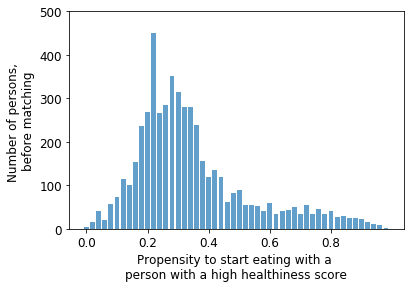

In [44]:
n,bins,parches = plt.hist(clf.predict_proba(scaler.transform(X))[:,1], range = [0,1],bins = 50);
plt.close()

plt.bar(range(len(n)),n, width = 0.8, alpha = 0.7)
plt.xticks(range(len(n))[::10],bins[:-1][::10])
plt.xlabel('Propensity to start eating with a \nperson with a high healthiness score')
plt.ylabel('Number of persons, \nbefore matching')

plt.ylim([0,500])

plt.savefig("fig_matching1.pdf", bbox_inches='tight')

In [12]:
props = clf.predict_proba(scaler.transform(X))[:,1]

In [13]:
features = ["shop at SHOP 0","shop at SHOP 2",
            "shop at SHOP 1","shop at SHOP 3","shop at SHOP 4",
            "% of transactions meals","% of transactions lunchtime",
            "weekly number of transactions","healthiness score"]

importances_sorted, features_sorted = zip(*sorted(zip(clf.feature_importances_, features)))

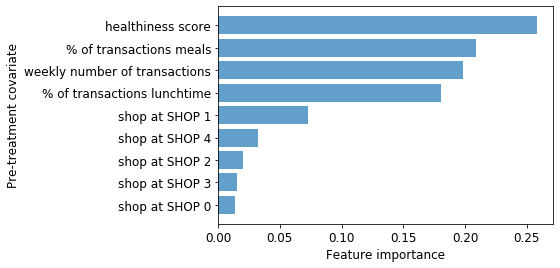

In [45]:
plt.barh(range(len(clf.feature_importances_)),importances_sorted, alpha = 0.7)
plt.yticks(range(len(clf.feature_importances_)),features_sorted)
plt.ylabel('Pre-treatment covariate')
plt.xlabel('Feature importance')

plt.savefig("fig_matching2.pdf", bbox_inches='tight')

In [15]:
max_dist = max((malanhobis_dist))

### c) build the bipartite graph to maximize similarity
1. require exact match on shop and tretreatment h-score
2. require propensity score to be within the calipher
3. maximize similarity based on malanhobis distance on the remaining three features

In [16]:
count = 0

#check the range of malanhobis distance, this is needed to convert distance to similarity
malanhobis_dist = []

#extract features control and treated used to fit propensities

X_treated_high = []
X_treated_low = []

propensities = []

G = nx.Graph()

for i in range(len(df_participants_single)):

    count +=1
    if count % 500 == 0:
        print(str(count)+'/'+str(len(df_participants_single)))
    
    
    if df_participants_single.iloc[i]["N"]>=10 and df_participants_single.iloc[i]["partner_score_pre_treatment"] >= 0.05:


        scores = df_participants_single.iloc[i]["monthly_scores"]

        start = int(df_participants_single.iloc[i]["start_treatment"])

        avg_pre = np.nanmean(scores[start-5:start+1])
        avg_post = np.nanmean(scores[start+1:start+7])

        months_pre = np.array(range(len(scores)))[start-5:start+1]
        months_post = np.array(range(len(scores)))[start+1:start+7]

        if np.isnan(avg_pre):
            continue

        if len(stats.mode([t[0] for t in df_participants_single.iloc[i]["shops"][start-5:start+1] if t[0]!=110], axis = None)[0]) == 0:
            continue

        shop_treated = stats.mode([t[0] for t in df_participants_single.iloc[i]["shops"][start-5:start+1] if t[0]!=110], axis = None)[0][0]


        #filters
        potential_controls = df_participants_single.loc[
            #take into account everyone except for them
            (df_participants_single["ID"]!= df_participants_single.iloc[i]["ID"]) & 
            #find people that have the intervention in the same month
            (df_participants_single["start_treatment"] == start) &
            #keep potential whose partner has negative score
            (df_participants_single["partner_score_pre_treatment"] <=-0.05) &
            #and they also have tie
            (df_participants_single["N"] >=10) &
            #and they made some purcahses in the same period
            (~(df_participants_single["monthly_scores"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean).apply(np.isnan)))
        ].copy(deep =True)


        #do an exact match on the most frequent shop they go to
        potential_controls = potential_controls.loc[potential_controls["shops"] \
              .apply(lambda x : x[start-5:start+1]).apply(lambda x: stats.mode([t[0] for t in x if t[0]!=110], axis = None)[0][0])
              .apply(lambda x: x == shop_treated)]

        #do an exact match on the initial h-score
        potential_controls = potential_controls.loc[potential_controls["monthly_scores"] \
              .apply(lambda x : x[start-5:start+1]).apply(np.nanmean) \
              .apply(lambda x: np.absolute(avg_pre - x)<=0.2)]


        if len(potential_controls)!=0:

            #pre-treatment h-score for controls
            h_scores = (potential_controls["monthly_scores"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre-treatment percentage meals for controls
            meals = (potential_controls["meals_percentage"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre-treatment percentage lunchtime for controls
            lunchtime = (potential_controls["lunchtime_percentage"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre_treatment transactions per month for controls
            number = (potential_controls["transactions_per_month"].apply(lambda x : x[start-5:start+1]).apply(np.nanmean)).values

            #pre_treatment most frequent shop for controls
            shop = (potential_controls["shops"].apply(lambda x : x[start-5:start+1]).apply(lambda x: stats.mode([t[0] for t in x if t[0]!=110], axis = None)[0][0])).values


            X_c = np.concatenate((shop.reshape(len(h_scores),1),
                               meals.reshape(len(h_scores),1),
                               lunchtime.reshape(len(h_scores),1),
                               number.reshape(len(h_scores),1),
                               h_scores.reshape(len(h_scores),1)),axis = 1)

            X_treated_low.append(X_c)

            X_treated_high.append([shop_treated,np.nanmean(df_participants_single.iloc[i]["meals_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["lunchtime_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["transactions_per_month"][start-5:start+1]),
                   avg_pre])


            treated_index = df_participants_single.iloc[i]["ID"]
            control_indices = potential_controls["ID"].values   


            t = [shop_treated,np.nanmean(df_participants_single.iloc[i]["meals_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["lunchtime_percentage"][start-5:start+1]),
                   np.nanmean(df_participants_single.iloc[i]["transactions_per_month"][start-5:start+1]),
                   avg_pre]

            t_encoded = np.concatenate((enc.transform(t[0].reshape(1, -1)).toarray()[0], t[1:]))         
            propensities.append(clf.predict_proba(scaler.transform(t_encoded.reshape(1, -1)).reshape(1, -1))[0][1])
            prop_t = clf.predict_proba(scaler.transform(t_encoded.reshape(1, -1)).reshape(1, -1))[0][1]


            for cnt,c in enumerate(X_c):
                c_encoded = np.concatenate((enc.transform(c[0].reshape(1, -1)).toarray()[0], c[1:]))         
                propensities.append(clf.predict_proba(scaler.transform(c_encoded.reshape(1, -1)).reshape(1, -1))[0][1])
                prop_c = clf.predict_proba(scaler.transform(c_encoded.reshape(1, -1)).reshape(1, -1))[0][1]

                #only if within the calipher, create an edge
                
                if np.abs(prop_t - prop_c) < 0.1:
                    G.add_weighted_edges_from([('c'+control_indices[cnt],'t'+treated_index,
                                            1 - distance.mahalanobis(c[1:-1],np.array(X_treated_high[-1])[1:-1],VI) / max_dist)])


500/5039
1000/5039
1500/5039
2000/5039
2500/5039
3000/5039
3500/5039
4000/5039
4500/5039
5000/5039


In [17]:
#maximize total similarity to find maximal matching
matching = nx.max_weight_matching(G)

### 5. Analysis of the quality of matching

In [18]:
#the 415 pairs of 830 matched focal persons
len(matching)

415

In [19]:
# 415 persons who start eating with a person that has a healthy eating patters
# are matched with 415 persons, undistinguishable up until the moment of onset
# who, in the same month, start eating with a person that has an unhealthy eating pattern

In [20]:
matched_treated_high = []
matched_treated_low = []

for i in matching:
    if str(i[1])[0] == 't':
        matched_treated_high.append(str(i[1])[1:])
        matched_treated_low.append(str(i[0])[1:])
    else:
        matched_treated_low.append(str(i[1])[1:])
        matched_treated_high.append(str(i[0])[1:])

diff = []
Ns = []

s_t = []
s_c = []

s_t_post = []
s_c_post = []

n_t = []
n_c = []

l_t = []
l_c = []

m_t = []
m_c = []

partner_low = []
partner_high = []


partner_pre_score = []

for i in range(len(matching)):
    scores_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["monthly_scores"].iloc[0]
    lunch_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["lunchtime_percentage"].iloc[0]
    meals_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["meals_percentage"].iloc[0]
    number_t = df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["transactions_per_month"].iloc[0]
    
    scores_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["monthly_scores"].iloc[0]
    lunch_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["lunchtime_percentage"].iloc[0]
    meals_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["meals_percentage"].iloc[0]
    number_c = df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["transactions_per_month"].iloc[0]
    
    
    start = int(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["start_treatment"])
    
    
    s_t.append(np.nanmean(scores_t[:start+1]))
    s_c.append(np.nanmean(scores_c[:start+1]))
    
    s_t_post.append(np.nanmean(scores_t[start+1:start+13]))
    s_c_post.append(np.nanmean(scores_c[start+1:start+13]))

    l_t.append(np.nanmean(lunch_t[:start+1]))
    l_c.append(np.nanmean(lunch_c[:start+1]))
    
    m_t.append(np.nanmean(meals_t[:start+1]))
    m_c.append(np.nanmean(meals_c[:start+1]))
    
    n_t.append(np.nanmean(number_t[:start+1]))
    n_c.append(np.nanmean(number_c[:start+1]))
    
    partner_low.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_low[i]]["partner_score_pre_treatment"].iloc[0])
    partner_high.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["partner_score_pre_treatment"].iloc[0])
    

    Ns.append(df_participants_single.loc[df_participants_single["ID"] == matched_treated_high[i]]["N"].iloc[0])
c_pre = s_c
t_pre = s_t
c_post = s_c_post
t_post = s_t_post

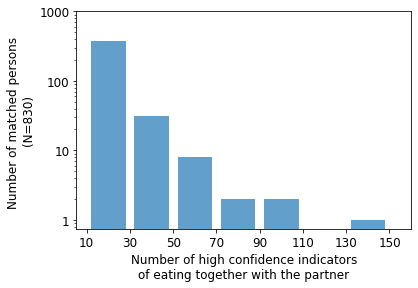

In [46]:
ns, bins, patches = plt.hist(Ns, range = [10,150], bins = 7)
plt.close()

plt.bar(range(len(ns)),ns, alpha = 0.7)
plt.xticks(range(len(bins)))
plt.yscale('log')
plt.xticks(np.array(range(len(bins)))-0.5,[str(i)[:-2] for i in bins])
plt.yticks([1,10,100,1000],[1,10,100,1000]);

plt.xlabel('Number of high confidence indicators\nof eating together with the partner')
plt.ylabel('Number of matched persons \n(N=830)')

plt.savefig("fig_matching3.pdf", bbox_inches='tight')

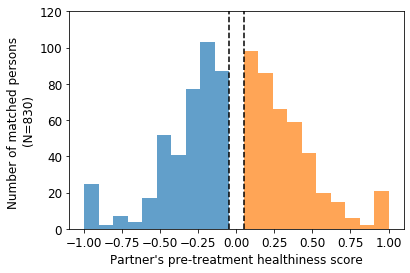

In [47]:
plt.hist(partner_low, range = [-1,1], bins = 21, alpha = 0.7)
plt.hist(partner_high, range = [-1,1], bins = 21, alpha = 0.7)
plt.vlines(0.05,0,120, linestyle = '--')
plt.vlines(-0.05,0,120, linestyle = '--')
plt.ylim([0,120])

plt.xlabel('Partner\'s pre-treatment healthiness score')
plt.ylabel('Number of matched persons \n(N=830)')

plt.savefig("fig_matching4.pdf", bbox_inches='tight')

In [23]:
def SMD(treated_vec, control_vec):
    pos_mean = np.nanmean(treated_vec)
    neg_mean = np.nanmean(control_vec)

    pos_std = np.std(treated_vec)
    neg_std = np.std(control_vec)
    smd = (pos_mean - neg_mean) / np.sqrt((pos_std ** 2 + neg_std ** 2) / 2)
    
    return round(abs(smd), 4)

In [24]:
X_treated_high = np.array(X_treated_high)
X_treated_low = np.array(X_treated_low)

In [25]:
features = ["% of transactions meals","% of transactions lunchtime",
            "weekly number of transactions","healthiness score"]


### SMD before matching

In [27]:
#1 - meals
#2 - lunchtime
#3 - number of transactions
#4 - healthiness score


for i in range(1,5):
    print(i)
    print(SMD(np.concatenate(X_treated_low,axis = 0)[:,i],np.array(X_treated_high)[:,i] ))
    print('\n')

1
0.2073


2
0.1095


3
0.0707


4
0.3009




### SMD after matching

In [28]:
print(SMD(s_c,s_t))
print(SMD(l_c,l_t))
print(SMD(m_c,m_t))
print(SMD(n_c,n_t))

0.0223
0.0453
0.075
0.0235
